# Analysis around bus stop

### Neccessary libraries to import

In [1]:
import folium
import numpy as np
import pandas as pd
import seaborn as sns
import geopy.distance
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from geopandas import GeoDataFrame
from shapely.geometry import Point
from folium.plugins import HeatMap
from geopandas import GeoDataFrame
from pyproj import CRS, Transformer
from typing import Dict, List, Tuple
from geopy.distance import distance as geopy_distance

### Neccesary functions to define

In [2]:
def convert_bng_to_latlon(chunk: pd.DataFrame) -> pd.DataFrame:
    """
    Converts British National Grid coordinates to latitude and longitude using WGS84 CRS.

    Args:
        chunk: DataFrame containing 'Location_Easting' and 'Location_Northing' columns.

    Returns:
        DataFrame: The input DataFrame with additional 'Latitude' and 'Longitude' columns.
    """
    bng_crs = CRS.from_string('EPSG:27700')  # British National Grid CRS
    wgs84_crs = CRS.from_string('EPSG:4326')  # WGS84 CRS (latitude, longitude)

    transformer = Transformer.from_crs(bng_crs, wgs84_crs, always_xy=True)

    # Apply the coordinate transformation to each row of the chunk DataFrame
    chunk[['Longitude', 'Latitude']] = chunk.apply(
        lambda row: pd.Series(transformer.transform(row['Location_Easting'], row['Location_Northing'])),
        axis=1
    )

    return chunk

In [3]:
def assign_bus_stops_to_lsoa(bus_df: pd.DataFrame, Barnet_df: pd.DataFrame, london_lsoa: GeoDataFrame) -> Dict[str, List[int]]:
    """Assigns bus stops to corresponding LSOAs (Lower Layer Super Output Areas) based on their geographic coordinates.

    Args:
        bus_df (DataFrame): DataFrame containing bus stop data with columns 'Latitude' and 'Longitude'.
        Barnet_df (DataFrame): DataFrame containing LSOA names.
        london_lsoa (GeoDataFrame): GeoDataFrame containing LSOA boundaries.

    Returns:
        Dict[str, List[int]]: A dictionary mapping LSOA names to a list of corresponding bus stop indices.
    """
    
    # Get the unique LSOA names from Barnet_df
    Barnet_LSOA = Barnet_df['LSOA name'].unique()

    # Create a dictionary to store the LSOA names and the corresponding bus stops
    lsoa_bus_stops = {}

    print(f'There are {len(Barnet_LSOA)} LSOAs to be processed.')
    
    counter = 0
    # Iterate over each LSOA name
    for lsoa_name in Barnet_LSOA:
        # Filter the LSOA data based on the specified name
        filtered_lsoa = london_lsoa[london_lsoa['lsoa11nm'] == lsoa_name]
        
        # Iterate over each row in the bus_df DataFrame
        for index, row in bus_df.iterrows():
            # Get the easting and northing coordinates
            northing = row['Latitude']
            easting = row['Longitude']
            
            # Check if the bus stop falls within the filtered LSOA boundaries
            point = Point(easting, northing)
            if filtered_lsoa.geometry.contains(point).any():
                # Add the LSOA name as an attribute to the bus stop
                bus_df.at[index, 'LSOA name'] = lsoa_name
                # Add the bus stop to the dictionary of LSOA names and bus stops
                if lsoa_name in lsoa_bus_stops:
                    lsoa_bus_stops[lsoa_name].append(index)
                else:
                    lsoa_bus_stops[lsoa_name] = [index]
        
        # Remove the checked LSOA name from further iterations
        if lsoa_name in lsoa_bus_stops:
            for stop_index in lsoa_bus_stops[lsoa_name]:
                bus_df.at[stop_index, 'Checked'] = True

        counter += 1
        print(f'{counter}. {lsoa_name} was processed.')

    # Display the dictionary of LSOA names and the corresponding bus stops
    return lsoa_bus_stops

In [4]:
def count_burglaries_within_distance(bus_location_df: pd.DataFrame, crime_df: pd.DataFrame, distance: float) -> pd.DataFrame:
    """
    Count the number of burglaries within a specified distance of each bus location.

    Args:
        bus_location_df: DataFrame containing bus locations with latitude and longitude columns.
        crime_df: DataFrame containing crime locations with latitude and longitude columns.
        distance: Distance in meters specifying the range for counting burglaries.

    Returns:
        The original bus location DataFrame with an additional column for burglary counts.

    """

    # Get the latitude and longitude values as arrays
    bus_locations = bus_location_df[['Latitude', 'Longitude']].values
    
    # Add a new column with the burglary counts to the bus location dataframe
    bus_location_df[f"{distance}_meter_away"] = 0
    
    # Iterate over each bus location
    for i, bus_location in enumerate(bus_locations):
        num_burglaries = 0
        # Iterate over each crime location
        for _, crime_row in crime_df.iterrows():
            crime_location = (crime_row['Latitude'], crime_row['Longitude'])
            
            # Calculate the distance between the bus and crime location
            dist = geopy_distance(bus_location, crime_location).meters
            
            # Increment the count if the distance is within the specified range
            if dist <= distance:
                num_burglaries += 1
        
        # Set the burglary count for the current bus location
        bus_location_df.at[i, f"{distance}_meter_away"] = num_burglaries
        print(f'{i} bus stops have been proceed.')

    return bus_location_df


In [5]:
def calculate_distance_to_nearest_bus(filtered_counts: pd.DataFrame, bus_locations: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the distance to the nearest bus stop for each location in filtered_counts DataFrame.

    Args:
        filtered_counts (pd.DataFrame): DataFrame containing locations to calculate distances for.
        bus_locations (pd.DataFrame): DataFrame containing bus stop locations.

    Returns:
        pd.DataFrame: DataFrame with added columns for distance to the nearest bus stop,
                      bus stop longitude, and bus stop latitude.
    """

    bus_locations = bus_locations[['Latitude', 'Longitude']]
    tree = KDTree(bus_locations)

    distances, indices = tree.query(filtered_counts[['Latitude', 'Longitude']], k=1)

    nearest_bus_stops = bus_locations.iloc[indices.flatten()]

    filtered_counts['distance to bus'] = [
        geopy.distance.distance((lat1, lon1), (lat2, lon2)).meters
        for (lat1, lon1), (lat2, lon2) in zip(
            filtered_counts[['Latitude', 'Longitude']].values,
            nearest_bus_stops.values
        )
    ]

    filtered_counts['bus_long'] = nearest_bus_stops['Longitude'].values
    filtered_counts['bus_lat'] = nearest_bus_stops['Latitude'].values

    return filtered_counts

In [6]:
def count_burglaries_within_distance(bus_location_df, crime_df, distance):
    # Get the latitude and longitude values as arrays
    bus_locations = bus_location_df[['Latitude', 'Longitude']].values
    
    # Add a new column with the burglary counts to the bus location dataframe
    bus_location_df[f"{distance}_meter_away"] = 0
    
    print(f'{len(bus_locations)} Bus station will be proccessed.')
    # Iterate over each bus location
    for i, bus_location in enumerate(bus_locations):
        num_burglaries = 0
    
        # Iterate over each crime location
        for _, crime_row in crime_df.iterrows():
            crime_location = (crime_row['Latitude'], crime_row['Longitude'])
            
            # Calculate the distance between the bus and crime location
            dist = geopy_distance(bus_location, crime_location).meters
            
            # Increment the count if the distance is within the specified range
            if dist <= distance:
                num_burglaries += 1
        
        # Set the burglary count for the current bus location
        bus_location_df.at[i, f"{distance}_meter_away"] = num_burglaries
        print(f'{i} Bus station has been proccessed.')
    return bus_location_df


In [7]:
def count_burglaries_within_distance(bus_location_df: pd.DataFrame, crime_df: pd.DataFrame, distance: int) -> Tuple[pd.DataFrame, int]:
    """
    Counts the number of crimes within a specified distance from each bus stop.

    Args:
        bus_location_df (pd.DataFrame): DataFrame containing bus stop locations.
        crime_df (pd.DataFrame): DataFrame containing crime locations.
        distance (int): Distance in meters to consider for counting crimes.

    Returns:
        Tuple[pd.DataFrame, int]: A tuple containing the modified bus location DataFrame with added columns for
                                  the number of crimes within the specified distance, and the number of unique crimes.
    """

    # Get the latitude and longitude values as arrays
    bus_locations = bus_location_df[['Latitude', 'Longitude']].values

    # Add a new column with the burglary counts to the bus location DataFrame
    bus_location_df[f"{distance}_meter_away"] = 0

    unique_crimes = set()  # Set to store unique crimes

    print(f'{len(bus_locations)} bus stations will be processed.')

    # Iterate over each bus location
    for i, bus_location in enumerate(bus_locations):
        num_burglaries = 0

        # Set to store unique crimes for the current bus location
        unique_crimes_for_bus = set()

        # Iterate over each crime location
        for crime_index in crime_df.index:
            crime_row = crime_df.loc[crime_index]
            crime_location = (crime_row['Latitude'], crime_row['Longitude'])

            # Calculate the distance between the bus and crime location
            dist = geopy.distance.distance(bus_location, crime_location).meters

            # Increment the count if the distance is within the specified range
            if dist <= distance:
                num_burglaries += 1
                unique_crimes_for_bus.add(crime_index)

        # Set the burglary count for the current bus location
        bus_location_df.at[i, f"{distance}_meter_away"] = num_burglaries

        # Update the set of unique crimes
        unique_crimes.update(unique_crimes_for_bus)

        print(f'{i+1} bus station has been processed.')

    return bus_location_df, len(unique_crimes)

### Cleaning up the bus stop dataframe

In [8]:
# Read the bus stops data from the CSV file into a DataFrame
bus_df = pd.read_csv("Data/Bus station analysis/bus-stops-10-06-15.csv")

In [9]:
# Filter out rows with NaN values in the 'Location_Easting' or 'Location_Northing' columns
bus_df = bus_df.dropna(subset=['Location_Easting', 'Location_Northing']).copy()

In [10]:
chunk_size: int = 10000
total_rows: int = len(bus_df)
processed_rows: int = 0

# Process DataFrame in chunks
for i in range(0, total_rows, chunk_size):
    # Extract a chunk of data
    chunk = bus_df.iloc[i:i+chunk_size].copy()
    
    # Convert British National Grid coordinates to latitude and longitude
    chunk = convert_bng_to_latlon(chunk)
    
    # Update processed rows count
    processed_rows += len(chunk)
    print(f"Processed {processed_rows} out of {total_rows} rows")
        
    # Update the original DataFrame with the chunk results
    bus_df.loc[i:i+chunk_size, ['Latitude', 'Longitude']] = chunk[['Latitude', 'Longitude']]

# Display the updated DataFrame
bus_df.head()

Processed 10000 out of 19800 rows
Processed 19800 out of 19800 rows


,Stop_Code_LBSL,Bus_Stop_Code,Naptan_Atco,Stop_Name,Location_Easting,Location_Northing,Heading,Stop_Area,Virtual_Bus_Stop,Latitude,Longitude
0,1000,91532,490000266G,WESTMINSTER STATION <> / PARLIAMENT SQUARE,530171.0,179738.0,177.0,0K08,0.0,51.501597,-0.125988
1,10001,72689,490013793E,TREVOR CLOSE,515781.0,174783.0,78.0,NB16,0.0,51.460191,-0.334831
2,10002,48461,490000108F,HIGHBURY CORNER,531614.0,184603.0,5.0,C902,0.0,51.544982,-0.103395
3,10003,77150,490000108B,HIGHBURY & ISLINGTON STATION <> #,531551.0,184803.0,127.0,C903,0.0,51.546794,-0.104228
4,10004,48037,490012451S,ST MARY MAGDALENE CHURCH,531365.0,184986.0,141.0,C904,0.0,51.548482,-0.106841


In [11]:
columns_to_drop = ['Location_Easting', 'Location_Northing', 'Heading', 'Virtual_Bus_Stop', 'Naptan_Atco', 'Bus_Stop_Code', 'Stop_Code_LBSL']

# Drop the specified columns from the DataFrame
bus_df = bus_df.drop(columns=columns_to_drop)
bus_df

,Stop_Name,Stop_Area,Latitude,Longitude
0,WESTMINSTER STATION <> / PARLIAMENT SQUARE,0K08,51.501597,-0.125988
1,TREVOR CLOSE,NB16,51.460191,-0.334831
2,HIGHBURY CORNER,C902,51.544982,-0.103395
3,HIGHBURY & ISLINGTON STATION <> #,C903,51.546794,-0.104228
4,ST MARY MAGDALENE CHURCH,C904,51.548482,-0.106841
...,...,...,...,...
19795,MORDEN STATION <>,LC07,51.402094,-0.194755
19796,MORDEN STATION <>,LC07,51.402489,-0.194092
19797,TILFORD AVENUE,H312,51.348410,-0.015337
19798,BETCHWORTH WAY,H313,51.347878,-0.017887


### Creating some visualization about bus stops

In [12]:
# Create a map centered around London
LondonMapWithBus = folium.Map(location=[51.5074, -0.1278], zoom_start=12)

# Iterate over each row in the dataframe
for index, row in bus_df.head(150).iterrows():
    # Get the latitude and longitude coordinates
    latitude = row['Latitude']
    longitude = row['Longitude']
    
    # Create a marker for each bus stop
    bicycle_icon = folium.Icon(icon='bus', prefix='fa', color='green')
    bus_stop_marker = folium.Marker(location=[latitude, longitude],
                                    popup=row['Stop_Name'],
                                    icon=bicycle_icon)
    
    # Add the marker to the map
    bus_stop_marker.add_to(LondonMapWithBus)

# Display the map
LondonMapWithBus

In [13]:
# Uncomment the save code line to save the image
# Save the map as an HTML file
# LondonMapWithBus.save("Pictures/Bus station analysis/LondonMapWithBus.html")

In [14]:
# Load the LSOA boundary data for London
london_lsoa = gpd.read_file('London.geojson')

# Filter the LSOA data for Barnet
barnet_lsoa = london_lsoa[london_lsoa['lsoa11nm'].str.contains('Barnet')]

In [15]:
# Create a map centered around London
BarnetMapWithBus = folium.Map(location=[51.5074, -0.1278], zoom_start=12)

# Iterate over each row in the dataframe
for index, row in bus_df.iterrows():
    # Get the latitude and longitude coordinates
    latitude = row['Latitude']
    longitude = row['Longitude']
    
    # Check if the bus stop falls within Barnet LSOA boundaries
    point = Point(longitude, latitude)
    if barnet_lsoa.geometry.contains(point).any():
        # Create a marker for each bus stop
        bicycle_icon = folium.Icon(icon='bus', prefix='fa', color='green')
        bus_stop_marker = folium.Marker(location=[latitude, longitude],
                                        popup=row['Stop_Name'],
                                        icon=bicycle_icon)
        
        # Add the marker to the map
        bus_stop_marker.add_to(BarnetMapWithBus)

# Display the map
BarnetMapWithBus

In [16]:
# Uncomment the save code line to save the image
# Save the map as an HTML file
# BarnetMapWithBus.save("Pictures/Bus station analysis/BarnetMapWithBus.html")

In [17]:
# Define the list of desired LSOA(hendon and west hendon)
desired_LSOA = ['Barnet 031A', 'Barnet 031B', 'Barnet 031C', 'Barnet 032A', 'Barnet 032B', 'Barnet 032C',
              'Barnet 032D', 'Barnet 032E', 'Barnet 034A', 'Barnet 034B', 'Barnet 034D', 'Barnet 031D',
              'Barnet 032F', 'Barnet 034C', 'Barnet 039D', 'Barnet 036B', 'Barnet 036C', 'Barnet 036D',
              'Barnet 036F']

In [18]:
# Filter the LSOA data based on the specified names
filtered_lsoa = london_lsoa[london_lsoa['lsoa11nm'].isin(desired_LSOA)]

# Create a map centered around London
DesiredWardsMap = folium.Map(location=[51.5074, -0.1278], zoom_start=12)

# Iterate over each row in the dataframe
for index, row in bus_df.iterrows():
    # Get the easting and northing coordinates
    latitude = row['Latitude']
    longitude = row['Longitude']
    
    # Check if the bus stop falls within the filtered LSOA boundaries
    point = Point(longitude, latitude)
    if filtered_lsoa.geometry.contains(point).any():
        # Create a marker for each bus stop
        bicycle_icon = folium.Icon(icon='bus', prefix='fa', color='green')
        bus_stop_marker = folium.Marker(location=[latitude, longitude],
                                        popup=row['Stop_Name'],
                                        icon=bicycle_icon)
        
        # Add the marker to the map
        bus_stop_marker.add_to(DesiredWardsMap)

# Display the map
DesiredWardsMap

In [19]:
# Uncomment the save code line to save the image
# Save the map as an HTML file
DesiredWardsMap.save("Pictures/Bus station analysis/DesiredWardsMap.html")

### Adding the LSOA name attribute to the each bus stop

In [20]:
# Read the data from the Parquet file 
df_burg = pd.read_parquet("Data/Bus station analysis/burglary.parquet")

# Drop rows with NaN values in "Longitude" and "Latitude" columns
df_burg.dropna(subset=['Longitude', 'Latitude'], inplace=True)

# Reset the index of the DataFrame after dropping rows
df_burg.reset_index(drop=True, inplace=True)

# Create a new DataFrame with rows containing 'Barnet' in LSOA name
Barnet_df = df_burg.loc[df_burg['LSOA name'].str.contains('Barnet')]

# Reset the index of the new DataFrame
Barnet_df.reset_index(drop=True, inplace=True)

# Get the count and unique values of LSOA names in the Barnet DataFrame
lsoa_count = len(Barnet_df['LSOA name'].unique())
Barnet_lsoa_names = Barnet_df['LSOA name'].unique()

lsoa_count, Barnet_lsoa_names

(211,
 array(['Barnet 001A', 'Barnet 001B', 'Barnet 001D', 'Barnet 001E',
        'Barnet 001F', 'Barnet 002A', 'Barnet 002D', 'Barnet 002E',
        'Barnet 003A', 'Barnet 003B', 'Barnet 003C', 'Barnet 004A',
        'Barnet 004D', 'Barnet 004E', 'Barnet 005A', 'Barnet 005B',
        'Barnet 005D', 'Barnet 006A', 'Barnet 006B', 'Barnet 006C',
        'Barnet 006D', 'Barnet 007A', 'Barnet 007B', 'Barnet 007D',
        'Barnet 007E', 'Barnet 007F', 'Barnet 008A', 'Barnet 008B',
        'Barnet 008C', 'Barnet 008E', 'Barnet 009B', 'Barnet 009D',
        'Barnet 009E', 'Barnet 010A', 'Barnet 010B', 'Barnet 010C',
        'Barnet 010D', 'Barnet 010E', 'Barnet 011B', 'Barnet 011C',
        'Barnet 011D', 'Barnet 011E', 'Barnet 012A', 'Barnet 012B',
        'Barnet 012C', 'Barnet 012D', 'Barnet 012E', 'Barnet 013B',
        'Barnet 013C', 'Barnet 013D', 'Barnet 013E', 'Barnet 013F',
        'Barnet 014A', 'Barnet 014B', 'Barnet 014C', 'Barnet 014D',
        'Barnet 014E', 'Barnet 014F', 'Bar

In [21]:
lsoa_bus_stops = assign_bus_stops_to_lsoa(bus_df, Barnet_df, london_lsoa)

There are 211 LSOAs to be processed.


KeyboardInterrupt: 

In [ ]:
# Iterate over the dictionary of LSOA names and bus stops
for lsoa_name, bus_stops in lsoa_bus_stops.items():
    # Add the LSOA name to the 'LSOA name' column for the corresponding bus stops
    bus_df.loc[bus_stops, 'LSOA name'] = lsoa_name

# Display the updated bus_df DataFrame
Barnet_bus = bus_df[bus_df['LSOA name'].isnull() == False].copy()
Barnet_bus

### Analyzing the relation between bus stops and the crime hot spots

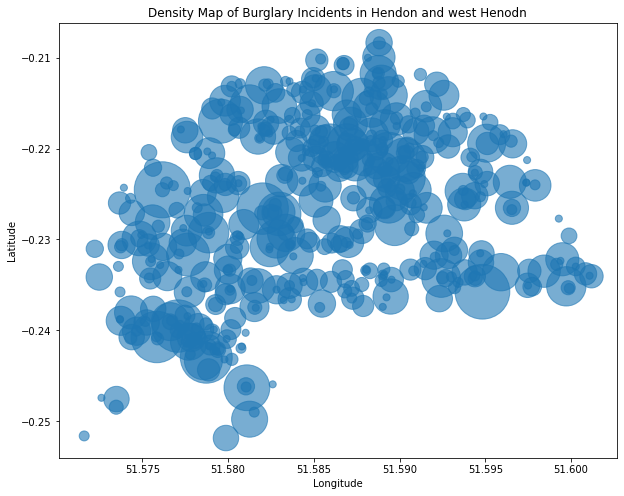

In [22]:
# Extract the data for burglary in the desired area(Hendon and west Hendon)
desired_burg = df_burg[df_burg['LSOA name'].isin(desired_LSOA)]
# Count the number of burglarys by the location
coor_burg = desired_burg[['Latitude', 'Longitude']].value_counts().rename_axis(['Latitude', 'Longitude']).reset_index(name='Count')

# Plot the density map
plt.figure(figsize=(10, 8))
plt.scatter(coor_burg['Latitude'], coor_burg['Longitude'], s=coor_burg['Count']*50, alpha=0.6)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Density Map of Burglary Incidents in Hendon and west Henodn')
plt.show()

In [23]:
# Uncomment the save code line to save the image
# Save the plot as an png file
# plt.savefig('Pictures/bus station analysis/DensityMapHendon.png')

In [24]:
# Filter the LSOA data based on the specified names
filtered_lsoa = london_lsoa[london_lsoa['lsoa11nm'].isin(desired_LSOA)]

# Create a map centered around London
HeatMapwithBus = folium.Map(location=[51.5074, -0.1278], zoom_start=12)

# Create a HeatMap layer for the density map
heat_data = [[row['Latitude'], row['Longitude'], row['Count']] for index, row in coor_burg.iterrows()]
HeatMap(heat_data).add_to(HeatMapwithBus)

# Iterate over each row in the dataframe
for index, row in bus_df.iterrows():
    # Get the easting and northing coordinates
    latitude = row['Latitude']
    longitude = row['Longitude']
    
    # Check if the bus stop falls within the filtered LSOA boundaries
    point = Point(longitude, latitude)
    if filtered_lsoa.geometry.contains(point).any():
        # Create a marker for each bus stop
        bicycle_icon = folium.Icon(icon='bus', prefix='fa', color='black', radius=3)
        bus_stop_marker = folium.Marker(location=[latitude, longitude],
                                        popup=row['Stop_Name'],
                                        icon=bicycle_icon)
        
        # Add the marker to the map
        bus_stop_marker.add_to(HeatMapwithBus)

# Display the map
HeatMapwithBus

In [25]:
# Uncomment the save code line to save the image
# Save the map as an HTML file
HeatMapwithBus.save('Pictures/Bus station analysis/HeatMapwithBus.html')

In [26]:
# Filter the LSOA data based on the specified names
filtered_lsoa = london_lsoa[london_lsoa['lsoa11nm'].isin(desired_LSOA)]

# Read the London GeoJSON file
london_geojson = gpd.read_file('London.geojson')

# Filter the GeoJSON data to include only the desired LSOA boundaries
filtered_geojson = london_geojson[london_geojson['lsoa11nm'].isin(desired_LSOA)]

# Create a map centered around London
HeatMapWithBusLSOA = folium.Map(location=[51.5074, -0.1278], zoom_start=12)

# Create a HeatMap layer for the density map
heat_data = [[row['Latitude'], row['Longitude'], row['Count']] for index, row in coor_burg.iterrows()]
HeatMap(heat_data).add_to(HeatMapWithBusLSOA)

# Add the LSOA boundaries to the map with black color
folium.GeoJson(filtered_geojson, style_function=lambda x: {'color': 'black'}).add_to(HeatMapWithBusLSOA)

# Iterate over each row in the dataframe
for index, row in bus_df.iterrows():
    # Get the easting and northing coordinates
    latitude = row['Latitude']
    longitude = row['Longitude']
    
    # Check if the bus stop falls within the filtered LSOA boundaries
    point = Point(longitude, latitude)
    if filtered_lsoa.geometry.contains(point).any():
        # Create a marker for each bus stop
        bicycle_icon = folium.Icon(icon='bus', prefix='fa', color='green')
        bus_stop_marker = folium.Marker(location=[latitude, longitude],
                                        popup=row['Stop_Name'],
                                        icon=bicycle_icon)
        
        # Add the marker to the map
        bus_stop_marker.add_to(HeatMapWithBusLSOA)

# Display the map
HeatMapWithBusLSOA


In [27]:
# Uncomment the save code line to save the image
# Save the map as an HTML file
# HeatMapWithBusLSOA.save('Pictures/Bus station analysis/HeatMapWithBusLSOA.html')

In [28]:
# Filter the LSOA data based on the specified names
filtered_lsoa = london_lsoa[london_lsoa['lsoa11nm'].isin(desired_LSOA)]

# Create a map centered around London
BubbleMapWithBus = folium.Map(location=[51.5074, -0.1278], zoom_start=12)

# Iterate over each row in the density data
for index, row in coor_burg.iterrows():
    # Get the latitude, longitude, and count
    latitude = row['Latitude']
    longitude = row['Longitude']
    count = row['Count']
    
    # Create a CircleMarker for each data point
    circle_marker = folium.CircleMarker(location=[latitude, longitude],
                                        radius=count,
                                        color='red',
                                        fill=True,
                                        fill_color='red',
                                        fill_opacity=0.6)
    
    # Add the CircleMarker to the map
    circle_marker.add_to(BubbleMapWithBus)

# Iterate over each row in the bus stop data
for index, row in bus_df.iterrows():
    # Get the easting and northing coordinates
    latitude = row['Latitude']
    longitude = row['Longitude']
    
    # Check if the bus stop falls within the filtered LSOA boundaries
    point = Point(longitude, latitude)
    if filtered_lsoa.geometry.contains(point).any():
        # Create a marker for each bus stop
        bicycle_icon = folium.Icon(icon='bus', prefix='fa', color='green')
        bus_stop_marker = folium.Marker(location=[latitude, longitude],
                                        popup=row['Stop_Name'],
                                        icon=bicycle_icon)
        
        # Add the marker to the map
        bus_stop_marker.add_to(BubbleMapWithBus)

# Display the map
BubbleMapWithBus

In [29]:
# Uncomment the save code line to save the image
# Save the map as an HTML file
# BubbleMapWithBus.save('Pictures/Bus station analysis/BubbleMapWithBus.html')

### The relation between the bus stop and their distance to the crime location

In [30]:
barnet_crime_count = Barnet_df['LSOA name'].value_counts()
barnet_crime_count

LSOA name
Barnet 038D    524
Barnet 035C    378
Barnet 027E    360
Barnet 002D    343
Barnet 018C    343
              ... 
Barnet 024B     90
Barnet 004F     80
Barnet 003C     80
Barnet 021C     77
Barnet 029F     73
Name: count, Length: 211, dtype: int64

In [31]:
barnet_bus_count = Barnet_bus['LSOA name'].value_counts()
barnet_bus_count

NameError: name 'Barnet_bus' is not defined

In [ ]:
sum(barnet_bus_count)

In [ ]:
# Filter the crime count and bus count to include only the common LSOA names
common_lsoa_names = list(set(barnet_crime_count.index) & set(barnet_bus_count.index))
filtered_barnet_crime_count = barnet_crime_count[common_lsoa_names]
filtered_barnet_bus_count = barnet_bus_count[common_lsoa_names]

# Create a DataFrame with the filtered counts
df = pd.DataFrame({'Crime Count': filtered_barnet_crime_count, 'Bus Count': filtered_barnet_bus_count})

# Calculate the correlation between the counts
correlation = df['Crime Count'].corr(df['Bus Count'])

# Print the correlation
print("Correlation between Crime Count and Bus Count:", correlation)

In [ ]:
# Create a scatter plot of the crime count and bus count
plt.scatter(df['Crime Count'], df['Bus Count'])
plt.xlabel('Crime Count')
plt.ylabel('Bus Count')
plt.title('Correlation between Crime Count and Bus Count')
plt.grid(True)

# Display the plot
plt.show()

In [ ]:
# Uncomment the save code line to save the image
# Save the plot as an png file
plt.savefig('correlation_plot.png')

### Calculating the Distance of each crime to the closest bus stop

In [ ]:
unique_location_combinations = len(Barnet_df.value_counts(['Longitude', 'Latitude']))
print("Number of unique combinations of longitude and latitude:", unique_location_combinations)

In [ ]:
count_threshold = 3
filtered_combinations = Barnet_df.value_counts(['Longitude', 'Latitude'])[Barnet_df.value_counts(['Longitude', 'Latitude']) >= count_threshold]
unique_filtered_combinations = len(filtered_combinations)
print("Number of unique combinations with count >= 3:", unique_filtered_combinations)

In [ ]:
count_threshold = 3
total_combinations = len(Barnet_df.value_counts(['Longitude', 'Latitude']))
filtered_combinations = len(Barnet_df.value_counts(['Longitude', 'Latitude'])[Barnet_df.value_counts(['Longitude', 'Latitude']) >= count_threshold])
rows_to_drop = total_combinations - filtered_combinations
print("Number of rows to drop:", rows_to_drop)

In [ ]:
count_threshold = 3
location_value_counts = Barnet_df.value_counts(['Longitude', 'Latitude'])
filtered_counts = location_value_counts[location_value_counts >= count_threshold]

# Create a larger figure
plt.figure(figsize=(15, 10))

# Create a distribution plot
sns.histplot(filtered_counts, kde=True)

# Set plot labels and title
plt.xlabel('Crime Count')
plt.ylabel('Frequency')
plt.title('Distribution of Crime counts for more than 3 crimes per location')

# Display the plot
plt.show()

In [ ]:
# Uncomment the save code line to save the image
# Save the plot as an png file
# plt.savefig('distribution_plot.png', dpi=300)

# checked till here

In [ ]:
filtered_counts = pd.DataFrame(filtered_counts).reset_index()
filtered_counts

In [ ]:
# Assuming filtered_counts is your DataFrame
filtered_counts['distance to bus'] = np.nan
filtered_counts

In [ ]:
Barnet_bus_location = Barnet_bus[['Longitude', 'Latitude']].reset_index()
Barnet_bus_location = Barnet_bus_location[['Longitude', 'Latitude']]
Barnet_bus_location

In [ ]:
filtered_counts = calculate_distance_to_nearest_bus(filtered_counts, Barnet_bus_location)
filtered_counts

In [ ]:
# Calculate the correlation between 'count' and 'distance to bus'
correlation = filtered_counts['count'].corr(filtered_counts['distance to bus'])
print(f"Correlation between 'count' and 'distance to bus': {correlation}")

# Create a scatter plot
plt.scatter(filtered_counts['distance to bus'], filtered_counts['count'])
plt.xlabel('Distance to Bus station')
plt.ylabel('Crime Count')
plt.title('Correlation between Count of Crimes and Distance to Bus stations')
plt.show()

In [ ]:
# Uncomment the save code line to save the image
# Save the plot as an png file
# plt.savefig('Pictures/Bus station analysis/CorrelationCrimeCountandDistancetoBus.png')

## season bus stops

In [ ]:
Barnet_df['Date month'] = pd.to_datetime(Barnet_df['Month']).dt.month

# Select values with the first 4 months of the year
selected_values = Barnet_df[Barnet_df['Date month'].isin([1, 2, 3, 4])]

# Print the selected values
selected_values['Month'].unique()

In [ ]:
# Assuming Barnet_df is your DataFrame containing the data
location_value_counts = selected_values.value_counts(['Longitude', 'Latitude'])
filtered_counts_season = location_value_counts[location_value_counts >= 0]

# Create a larger figure
plt.figure(figsize=(10, 6))

# Create a distribution plot
sns.histplot(filtered_counts_season, kde=True)

# Set plot labels and title
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Distribution of Counts')

# Display the plot
plt.show()

In [ ]:
filtered_counts_season = pd.DataFrame(filtered_counts_season).reset_index()
filtered_counts_season

In [ ]:
# Assuming filtered_counts is your DataFrame
filtered_counts_season['distance to bus'] = np.nan
filtered_counts_season

In [ ]:
Barnet_bus_location = Barnet_bus[['Longitude', 'Latitude']].reset_index()
Barnet_bus_location = Barnet_bus_location[['Longitude', 'Latitude']]
Barnet_bus_location

In [ ]:
calculate_distance_to_nearest_bus(filtered_counts_season, Barnet_bus_location)

In [ ]:
# Assuming subset_filtered_counts is your DataFrame with the 'count' and 'distance to bus' columns

# Calculate the correlation between 'count' and 'distance to bus'
correlation = filtered_counts_season['count'].corr(filtered_counts_season['distance to bus'])
print(f"Correlation between 'crime count' and 'distance to bus station' in first 4 months of the year: {correlation}")

## Number of crimes within X meters away from bus stops

In [32]:
Barnet_bus_location = Barnet_bus[['Longitude', 'Latitude']].reset_index()
Barnet_bus_location = Barnet_bus_location[['Longitude', 'Latitude']]
Barnet_bus_location

NameError: name 'Barnet_bus' is not defined

In [ ]:
distance = 100  # Specify the distance in meters
result_df, Nr_crimes = count_burglaries_within_distance(Barnet_bus_location, Barnet_df, distance)
result_df.to_csv(f'Data/Bus station analysis/{distance} from busstop.csv')

In [ ]:
Nr_crimes

till here

In [33]:
bus100away = pd.read_csv('Data/Bus station analysis/100 meters from busstop.csv')
bus100away

,Unnamed: 0,Longitude,Latitude,125_meter_away,100_meter_away
0,0,-0.177040,51.613719,96,70
1,1,-0.163915,51.588902,70,70
2,2,-0.248723,51.584101,59,12
3,3,-0.286509,51.616402,17,8
4,4,-0.271807,51.618245,44,2
...,...,...,...,...,...
960,960,-0.193920,51.571976,121,57
961,961,-0.194439,51.571993,125,115
962,962,-0.194053,51.571915,121,57
963,963,-0.194101,51.571799,126,120


In [34]:
df_burg

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
0,None,2010-12,Metropolitan Police Service,Metropolitan Police Service,0.140619,51.583427,On or near Rams Grove,E01000027,Barking and Dagenham 001A,Burglary,None,NaN
1,None,2010-12,Metropolitan Police Service,Metropolitan Police Service,0.128479,51.583414,On or near Cavalier Close,E01000028,Barking and Dagenham 001B,Burglary,None,NaN
2,None,2010-12,Metropolitan Police Service,Metropolitan Police Service,0.134801,51.578470,On or near Portland Close,E01000029,Barking and Dagenham 001C,Burglary,None,NaN
3,None,2010-12,Metropolitan Police Service,Metropolitan Police Service,0.131156,51.582323,On or near Lake Road,E01000029,Barking and Dagenham 001C,Burglary,None,NaN
4,None,2010-12,Metropolitan Police Service,Metropolitan Police Service,0.140466,51.584159,On or near Bagleys Spring,E01000030,Barking and Dagenham 001D,Burglary,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
901346,9f357b44c1ca5904ca6781cd1db762e4e05fc72c077096...,2023-03,Metropolitan Police Service,Metropolitan Police Service,-0.146307,51.490158,On or near,E01004750,Westminster 023E,Burglary,Under investigation,NaN
901347,300b85ef8fada665df0600a21c5e3fb495735149bb7f66...,2023-03,Metropolitan Police Service,Metropolitan Police Service,-0.150502,51.486519,On or near,E01033597,Westminster 023F,Burglary,Investigation complete; no suspect identified,NaN
901348,c7f1b71688cf60d5e20d9f6ca336e968131ec637b8017c...,2023-03,Metropolitan Police Service,Metropolitan Police Service,-0.141768,51.485949,On or near Churchill Gardens Road,E01004665,Westminster 024A,Burglary,Under investigation,NaN
901349,8e0ba5bd1312cd339677e33ed797b0945326c50f59309e...,2023-03,Metropolitan Police Service,Metropolitan Police Service,-0.133183,51.489842,On or near Rampayne Street,E01004737,Westminster 024C,Burglary,Investigation complete; no suspect identified,NaN


In [35]:
bus150away = pd.read_csv('Data/Bus station analysis/150 meters from busstop.csv')
sum(bus150away['150_meter_away'])

58708

In [56]:
bus100away.sort_values('100_meter_away', ascending=False)

,Unnamed: 0,Longitude,Latitude,125_meter_away,100_meter_away
37,37,-0.197343,51.572281,194,190
462,462,-0.195456,51.571092,169,147
612,612,-0.197421,51.562282,167,136
142,142,-0.200348,51.573649,152,136
141,141,-0.200877,51.573783,152,135
...,...,...,...,...,...
331,331,-0.193747,51.630208,0,0
831,831,-0.194381,51.661538,0,0
832,832,-0.190339,51.662456,0,0
113,113,-0.266564,51.617844,0,0


In [57]:
sum(bus150away['150_meter_away'])

58708

In [59]:
df_burg

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
0,None,2010-12,Metropolitan Police Service,Metropolitan Police Service,0.140619,51.583427,On or near Rams Grove,E01000027,Barking and Dagenham 001A,Burglary,None,NaN
1,None,2010-12,Metropolitan Police Service,Metropolitan Police Service,0.128479,51.583414,On or near Cavalier Close,E01000028,Barking and Dagenham 001B,Burglary,None,NaN
2,None,2010-12,Metropolitan Police Service,Metropolitan Police Service,0.134801,51.578470,On or near Portland Close,E01000029,Barking and Dagenham 001C,Burglary,None,NaN
3,None,2010-12,Metropolitan Police Service,Metropolitan Police Service,0.131156,51.582323,On or near Lake Road,E01000029,Barking and Dagenham 001C,Burglary,None,NaN
4,None,2010-12,Metropolitan Police Service,Metropolitan Police Service,0.140466,51.584159,On or near Bagleys Spring,E01000030,Barking and Dagenham 001D,Burglary,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
901346,9f357b44c1ca5904ca6781cd1db762e4e05fc72c077096...,2023-03,Metropolitan Police Service,Metropolitan Police Service,-0.146307,51.490158,On or near,E01004750,Westminster 023E,Burglary,Under investigation,NaN
901347,300b85ef8fada665df0600a21c5e3fb495735149bb7f66...,2023-03,Metropolitan Police Service,Metropolitan Police Service,-0.150502,51.486519,On or near,E01033597,Westminster 023F,Burglary,Investigation complete; no suspect identified,NaN
901348,c7f1b71688cf60d5e20d9f6ca336e968131ec637b8017c...,2023-03,Metropolitan Police Service,Metropolitan Police Service,-0.141768,51.485949,On or near Churchill Gardens Road,E01004665,Westminster 024A,Burglary,Under investigation,NaN
901349,8e0ba5bd1312cd339677e33ed797b0945326c50f59309e...,2023-03,Metropolitan Police Service,Metropolitan Police Service,-0.133183,51.489842,On or near Rampayne Street,E01004737,Westminster 024C,Burglary,Investigation complete; no suspect identified,NaN


In [64]:
# Filter the LSOA data based on the specified names
filtered_lsoa = london_lsoa[london_lsoa['lsoa11nm'].isin(desired_LSOA)]

# Create a map centered around London
HeatMapwithBus = folium.Map(location=[51.5074, -0.1278], zoom_start=12)

# Create a HeatMap layer for the density map
heat_data = [[row['Latitude'], row['Longitude'], row['Count']] for index, row in coor_burg.iterrows()]
HeatMap(heat_data).add_to(HeatMapwithBus)
indecies = []
# Iterate over each row in the dataframe
for index, row in bus100away.sort_values('100_meter_away', ascending=False).iloc[hendon_bus_index].head(15).iterrows():
    # Get the easting and northing coordinates
    latitude = row['Latitude']
    longitude = row['Longitude']
    
    # Check if the bus stop falls within the filtered LSOA boundaries
    point = Point(longitude, latitude)
    if filtered_lsoa.geometry.contains(point).any():
        indecies.append(index)

        # Create a marker for each bus stop
        bicycle_icon = folium.Icon(icon='bus', prefix='fa', color='black', radius=3)
        bus_stop_marker = folium.Marker(location=[latitude, longitude],
                                        icon=bicycle_icon)
        
        # Add the marker to the map
        bus_stop_marker.add_to(HeatMapwithBus)

# Display the map
HeatMapwithBus

In [54]:
HeatMapwithBus.save('Pictures/Bus station analysis/topHeatMapwithBus.html')

In [63]:
bus100away.iloc[hendon_bus_index].head(15)

,Unnamed: 0,Longitude,Latitude,125_meter_away,100_meter_away
34,34,-0.225894,51.582841,125,72
46,46,-0.230769,51.585532,35,21
47,47,-0.231862,51.586744,36,7
48,48,-0.235147,51.587666,31,9
49,49,-0.233816,51.595550,28,28
50,50,-0.233419,51.595355,56,41
51,51,-0.233706,51.598012,52,32
52,52,-0.233269,51.599229,55,47
71,71,-0.238948,51.579324,38,9
83,83,-0.219125,51.593170,30,30


In [62]:
hendon_bus_index = indecies

In [ ]:
desired_burg